In [31]:
import numpy as np
import os
import scipy.io
from scipy.linalg import solve_continuous_are
import control
import matplotlib.pyplot as plt

In [32]:
class FligthControl:
    def __init__(self, matrice, CG_data, data, angle) -> None:
        # matrices du modèle MCEE
        self.A = matrice["A"]
        self.B = matrice["B"]

        # fichier.mat des différents centres de gravité
        self.GravityCenter = CG_data

        # angle des moteurs
        self.alpha = angle

        # dictionnaire des constantes de la simulation
        self.data = data
        self.inertie = data['inertie']
        self.m_tot = data['m_dirigeable'] + 4*data['m_comp_motor'] + data['m_nacelle']

        # centre de gravité + vecteur distance 
        self.CG_total, self.CG_components, self.CG_motor = self.CG_list()
        self.d_CG_P, self.d_CG_T = self.CGtoComponents()

        # méthode LQR
        self.K = self.design_lqr()

    def CG_list(self):

        CG_total = self.GravityCenter[list(self.GravityCenter.keys())[3:][0]][0]
        CG_components = self.GravityCenter[list(self.GravityCenter.keys())[3:][1]]
        CG_motor = self.GravityCenter[list(self.GravityCenter.keys())[3:][2]]
        
        return CG_total, CG_components, CG_motor
    
    def thrust_function(self, tension) -> np.array:
        
        tension = np.array(tension)
        thrust = 0.048 * np.square(tension) - 0.011 * tension + 0.009

        return thrust
    
    def CGtoComponents(self):

        d_CG_P = np.array([self.CG_total - CG_components_w for CG_components_w in self.CG_components])
        d_CG_T = np.array([self.CG_total - CG_components_t for CG_components_t in self.CG_motor])

        return d_CG_P, d_CG_T
    
    def force_moment(self, tensions):
        forces = np.zeros((3, 1))
        moments = np.zeros((3, 1))

        # calcul des forces 
        thrust_norm = self.thrust_function(tensions)
        F_mot = np.array([thrust_norm[mot] * np.array([np.cos(self.alpha[mot]), 0, np.sin(self.alpha[mot])]) for mot in range(4)])
        P_mot = P_mot = np.tile([0, 0, -self.data['m_comp_motor'] * self.data['gravity']], (4, 1))
        
        # Concaténation des vecteurs F_mot et P_mot
        forces = np.concatenate((F_mot, P_mot), axis=0)
        resultant_force = np.sum(forces, axis=0)

        # calcul des moments
        moments = np.array([np.cross(d, f) for d, f in zip(np.concatenate((self.d_CG_T, self.d_CG_P), axis=0), forces)])
        resultant_moments = np.sum(moments, axis=0)
        return resultant_force, resultant_moments

    def update_matrices(self, X_eq):
        # Mise à jour des matrices A et B en fonction de X_eq
        qr = (self.inertie['I_y'] - self.inertie['I_z'])/self.inertie['I_x']
        pr = (self.inertie['I_z'] - self.inertie['I_x'])/self.inertie['I_y']
        pq = (self.inertie['I_x'] - self.inertie['I_y'])/self.inertie['I_z']
        
        A = np.array([
            [0, X_eq[5], -X_eq[4], 0, X_eq[2], -X_eq[1]],
            [-X_eq[5], 0, X_eq[3], -X_eq[2], 0, X_eq[0]],
            [X_eq[4], X_eq[3], 0, X_eq[1], -X_eq[0], 0],
            [0, 0, 0, 0, qr, pr],
            [0, 0, 0, -qr, 0, pq],
            [0, 0, 0, -pr, -pq, 0]
        ])
        
        B = np.array([
            [1/self.m_tot, 0, 0, 0, 0, 0],
            [0, 1/self.m_tot, 0, 0, 0, 0],
            [0, 0, 1/self.m_tot, 0, 0, 0],
            [0, 0, 0, 1/self.inertie['I_x'], 0, 0],
            [0, 0, 0, 0, 1/self.inertie['I_y'], 0],
            [0, 0, 0, 0, 0, 1/self.inertie['I_z']]
        ])
        
        self.A = A
        self.B = B
        self.K = self.design_lqr()
    
    def design_lqr(self):
        # Définir les matrices de pondération Q et R
        Q = np.eye(self.A.shape[0])  # Ajustez selon vos besoins
        R = np.eye(self.B.shape[1])  # Ajustez selon vos besoins
        
        # Résoudre l'équation de Riccati pour trouver P
        P = solve_continuous_are(self.A, self.B, Q, R)
        
        # Calculer le gain de retour d'état K
        K = np.linalg.inv(R) @ self.B.T @ P
        return K

    def control(self, X):
        # Calculer la commande en temps réel
        U = -self.K @ X
        return U

In [33]:
data_repo = os.path.join(os.getcwd(), 'data')
CG_data = scipy.io.loadmat(os.path.join(data_repo, 'CG_data.mat'))

a = 3
b = 0.75
c = 0.75

m_dirigeable = 3
m_comp_motor = 0.1415
m_nacelle = 0.75

m_tot = m_dirigeable + 4*m_comp_motor + m_nacelle

I_x = (1/5) * m_dirigeable * (np.square(b) + np.square(c))
I_y = (1/5) * m_dirigeable * (np.square(a) + np.square(c))
I_z = (1/5) * m_dirigeable * (np.square(a) + np.square(b))

inertie = {
    'I_x': I_x,
    'I_y': I_y,
    'I_z': I_z
}

qr = (inertie['I_y'] - inertie['I_z'])/inertie['I_x']
pr = (inertie['I_z'] - inertie['I_x'])/inertie['I_y']
pq = (inertie['I_x'] - inertie['I_y'])/inertie['I_z']

matrix = {
    'A': np.array([0, 0, 0]),
    'B': np.array([0, 0, 0])
}

# normalement continuellement mise à jour avec les capteurs à l'instant t-dt
X_eq = np.array([0.1, 0.1, 0.1, 0.2, 0.1, 0.3]).reshape((6, ))

A = np.array([
    [0, X_eq[5], -X_eq[4], 0, X_eq[2], -X_eq[1]],
    [-X_eq[5], 0, X_eq[3], -X_eq[2], 0, X_eq[0]],
    [X_eq[4], X_eq[3], 0, X_eq[1], -X_eq[0], 0],
    [0, 0, 0, 0, qr, pr],
    [0, 0, 0, -qr, 0, pq],
    [0, 0, 0, -pr, -pq, 0]
])

B = np.array([
    [1/m_tot, 0, 0, 0, 0, 0],
    [0, 1/m_tot, 0, 0, 0, 0],
    [0, 0, 1/m_tot, 0, 0, 0],
    [0, 0, 0, 1/inertie['I_x'], 0, 0],
    [0, 0, 0, 0, 1/inertie['I_y'], 0],
    [0, 0, 0, 0, 0, 1/inertie['I_z']]
])

C = np.array([
    [0, 0, 0, 1, 0, 0],  # Pour le moment de roulis
    [0, 0, 0, 0, 1, 0]   # Pour le moment de tangage
])

matrix = {
    'A': A,
    'B': B,
    'C': C
}

data = {
    'm_comp_motor': m_comp_motor,
    'm_nacelle': m_nacelle,
    'm_dirigeable': m_dirigeable,
    'inertie': inertie,
    'gravity': 9.80665
}

angle = np.array([np.pi/4, np.pi/4, np.pi/4, np.pi/4])

In [34]:
tensions = np.array([5, 5, 5, 5]) 
FC = FligthControl(matrix, CG_data, data, angle)

<Figure size 1200x1000 with 0 Axes>

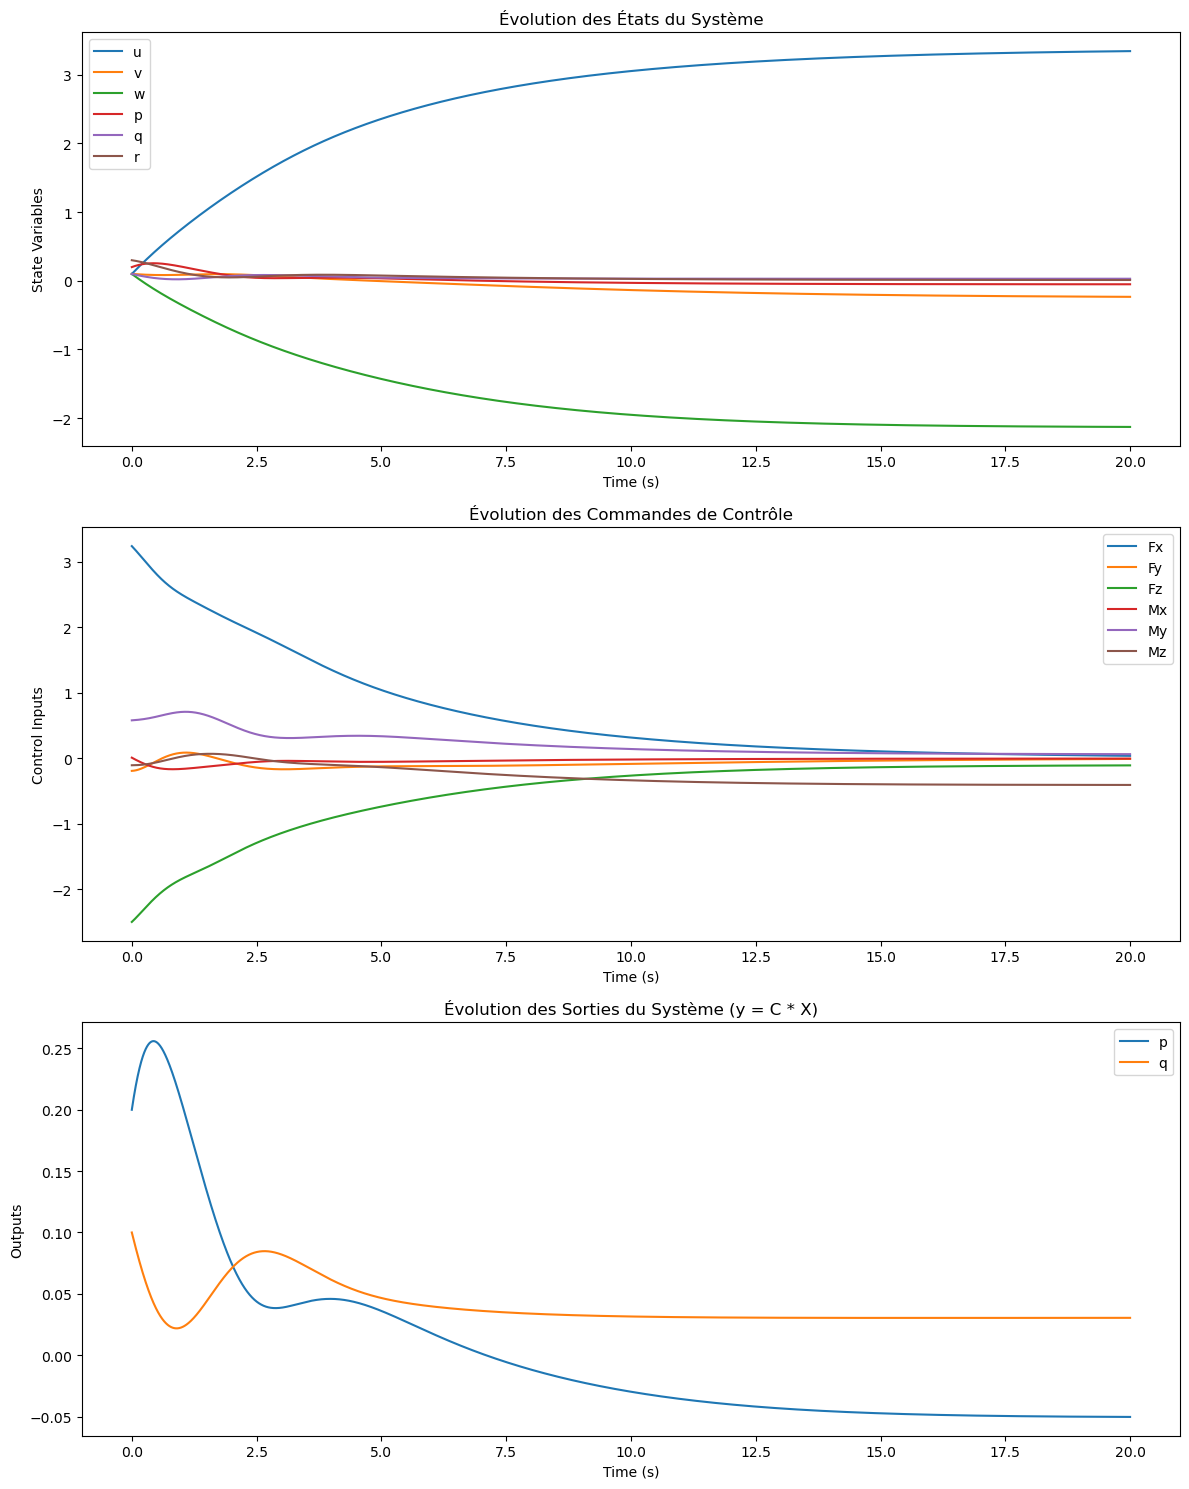

In [35]:
# Initialisation de l'état initial
X_current = np.array([0.1, 0.1, 0.1, 0.2, 0.1, 0.3]).reshape((6, ))

# Simulation en temps réel
dt = 0.001  # Intervalle de temps
T = 20  # Temps de simulation
num_steps = int(T / dt)

X_hist = np.zeros((len(X_current), num_steps))
U_hist = np.zeros((FC.B.shape[1], num_steps))
Y_hist = np.zeros((C.shape[0], num_steps))

for k in range(num_steps):
    FC.update_matrices(X_current)
    
    U = FC.control(X_current)
    
    forces, moments = FC.force_moment(tensions)
    U += np.concatenate((forces, moments))
    
    # Calcul de la sortie Y
    Y = C @ X_current
    
    # Stocker l'état, la commande et la sortie pour affichage
    X_hist[:, k] = X_current.flatten()
    U_hist[:, k] = U.flatten()
    Y_hist[:, k] = Y.flatten()
    
    # Mettre à jour l'état (ici nous utilisons une intégration simple Euler pour la simulation)
    X_current = X_current + (FC.A @ X_current + FC.B @ U) * dt

# Tracer les résultats
time = np.linspace(0, T, num_steps)

plt.figure(figsize=(12, 10))

plt.figure(figsize=(12, 15))

# Tracé des états
plt.subplot(3, 1, 1)
plt.plot(time, X_hist.T)
plt.xlabel('Time (s)')
plt.ylabel('State Variables')
plt.legend(['u', 'v', 'w', 'p', 'q', 'r'])
plt.title('Évolution des États du Système')

# Tracé des commandes de contrôle
plt.subplot(3, 1, 2)
plt.plot(time, U_hist.T)
plt.xlabel('Time (s)')
plt.ylabel('Control Inputs')
plt.legend(['Fx', 'Fy', 'Fz', 'Mx', 'My', 'Mz'])
plt.title('Évolution des Commandes de Contrôle')

# Tracé des sorties y = C * X
plt.subplot(3, 1, 3)
plt.plot(time, Y_hist.T)
plt.xlabel('Time (s)')
plt.ylabel('Outputs')
plt.legend(['p', 'q'])
plt.title('Évolution des Sorties du Système (y = C * X)')

plt.tight_layout()
plt.show()